# Homework 2, Question C:  Logistic Regression - Product Return
### Sean Olson

In [1]:
## Import Libraries
# import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from scipy.stats import skew

%matplotlib inline

# import statistical visualization library
import seaborn as sns

# import supervised learning libraries
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE, RFECV

# import regression libraries
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix, classification_report, roc_auc_score, roc_curve

# suppress warnings
pd.options.mode.chained_assignment = None
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Load data into pandas dataframe

data = pd.read_excel('/Users/seanolson/OneDrive/Documents/UNC Chapel Hill/Kenan-Flagler Business School/KFBS Courses/MBA706 Data Analytics/Week 2/Customer+Transaction+Data.xlsx', sheet_name = 'Data')
print(data.head())

   custid  month   purchase channel_purchase  spend  items  discount_availed  \
0       1       1         0              NaN    NaN    NaN               NaN   
1       1       2         1            Store  347.9    6.0               0.0   
2       1       3         1              Web    6.0    1.0               0.0   
3       1       4         0              NaN    NaN    NaN               NaN   
4       1       5         0              NaN    NaN    NaN               NaN   

   product_return  month_elapsed  catalog_sent  coupon_sent  items_todate  \
0             NaN              0             0            0             0   
1             1.0              1             1            0             0   
2             0.0              0             1            0             6   
3             NaN              0             1            0             7   
4             NaN              1             1            1             7   

   spend_todate  
0           0.0  
1           0.0  
2 

In [3]:
# check on missing values per column
print("Check Nulls - Main Dataframe")
print("----------------------------")
print(data.isnull().sum())

Check Nulls - Main Dataframe
----------------------------
custid                 0
month                  0
purchase               0
channel_purchase    1294
spend               1294
items               1294
discount_availed    1294
product_return      1294
month_elapsed          0
catalog_sent           0
coupon_sent            0
items_todate           0
spend_todate           0
dtype: int64


## Logistic Regression Question C:  Decision to Return a Purchased Product

#### We will follow the same steps for the Logistic Regression in Question A.  Though these will be different models, the steps will be the same to ensure consistency in model creation, so any differences are due to the data and not the procedure.

In [4]:
# Dataframe Creation
# create binary variables
log2_data = data.copy()

# create empty columns
log2_data['catalog'] = np.nan
log2_data['store'] = np.nan
log2_data['web'] = np.nan

# fill columns with binary outcome
for i in range(0, len(log2_data)):
    if log2_data['channel_purchase'][i] == 'Catalog':
        log2_data['catalog'][i] = 1
    else:
        log2_data['catalog'][i] = 0
    
    if log2_data['channel_purchase'][i] == 'Store':
        log2_data['store'][i] = 1
    else:
        log2_data['store'][i] = 0
    
    if log2_data['channel_purchase'][i] == 'Web':
        log2_data['web'][i] = 1
    else:
        log2_data['web'][i] = 0

# drop channel_purchase column
log2_data = log2_data.drop(['channel_purchase'], axis = 1)
        
# fill in NaN on discount_availed, product_return, spend, items with 0
columns = ['spend', 'items', 'discount_availed', 'product_return']

for cols in columns:
    log2_data[cols] = log2_data[cols].fillna(0)

print(log2_data.head())

   custid  month   purchase  spend  items  discount_availed  product_return  \
0       1       1         0    0.0    0.0               0.0             0.0   
1       1       2         1  347.9    6.0               0.0             1.0   
2       1       3         1    6.0    1.0               0.0             0.0   
3       1       4         0    0.0    0.0               0.0             0.0   
4       1       5         0    0.0    0.0               0.0             0.0   

   month_elapsed  catalog_sent  coupon_sent  items_todate  spend_todate  \
0              0             0            0             0           0.0   
1              1             1            0             0           0.0   
2              0             1            0             6         347.9   
3              0             1            0             7         353.9   
4              1             1            1             7         353.9   

   catalog  store  web  
0      0.0    0.0  0.0  
1      0.0    1.0  0.0  

Counts of 0,1 in product_return variable
----------------------------------------
0.0    1532
1.0      68
Name: product_return, dtype: int64

Bar Chart of Product_Return Counts


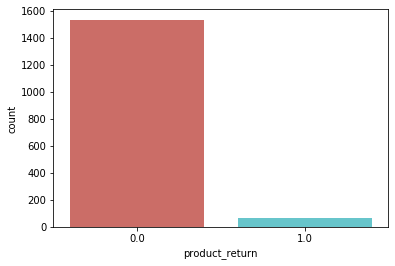


Percentages
-----------
Return:  4.25 %
No Return:  95.75 %


In [5]:
# Data Exploration
# counts of 0,1 in purchase
depcount = log2_data['product_return'].value_counts()
print('Counts of 0,1 in product_return variable')
print('----------------------------------------')
print(depcount)

# bar chart to see distribution of dependent variable
print('')
print('Bar Chart of Product_Return Counts')
sns.countplot(x = 'product_return', data = log2_data, palette = 'hls')
plt.show()

# find out percentage of each
count_no_ret = len(log2_data[log2_data['product_return'] == 0])
count_ret = len(log2_data[log2_data['product_return'] == 1])

pct_no_ret = count_no_ret/(count_no_ret + count_ret)
pct_ret = count_ret/(count_no_ret + count_ret)

print('')
print('Percentages')
print('-----------')
print('Return: ', pct_ret*100, '%')
print('No Return: ', pct_no_ret*100, '%')

In [6]:
# create X and Y variables
Xl = pd.DataFrame(np.c_[log2_data['custid'], log2_data['month '], log2_data['spend'], log2_data['items'],
                       log2_data['discount_availed'], log2_data['purchase'], log2_data['month_elapsed'],
                       log2_data['catalog_sent'], log2_data['coupon_sent'], log2_data['items_todate'],
                       log2_data['spend_todate'], log2_data['catalog'], log2_data['store'], log2_data['web']], 
                       columns = ['custid', 'month ', 'spend', 'items', 'discount_availed', 'purchase', 'month_elapsed',
                                  'catalog_sent', 'coupon_sent', 'items_todate', 'spend_todate', 'catalog', 'store', 'web'])
Yl = log2_data['product_return']

In [7]:
# setup SMOTE analysis from imblearn library
os2 = SMOTE(random_state = 0)

# split out training and testing data
Xl_train, Xl_test, Yl_train, Yl_test = train_test_split(Xl, Yl, test_size = 0.3, random_state = 0)
columns = Xl_train.columns

# fit SMOTE analysis
os_data_Xl, os_data_Yl = os2.fit_sample(Xl_train, Yl_train)

# create dataframes from SMOTE analysis
os_data_Xl = pd.DataFrame(data = os_data_Xl, columns = columns)
os_data_Yl = pd.DataFrame(data = os_data_Yl, columns = ['product_return'])

# check the outcome to determine if the dependent variable became balanced
print('Length of Oversampled data is {}'.format(len(os_data_Xl)))
print('Number of No Return in Oversampled data is {}'.format(len(os_data_Yl[os_data_Yl['product_return'] == 0])))
print('Number of Return in Oversampled data is {}'.format(len(os_data_Yl[os_data_Yl['product_return'] == 1])))
print('Proportion of No Return data in Oversampled data is {}'.format(len(os_data_Yl[os_data_Yl['product_return'] == 0])/len(os_data_Xl)))
print('Proportion of Return data in Oversampled data is {}'.format(len(os_data_Yl[os_data_Yl['product_return'] == 1])/len(os_data_Xl)))

Length of Oversampled data is 2146
Number of No Return in Oversampled data is 1073
Number of Return in Oversampled data is 1073
Proportion of No Return data in Oversampled data is 0.5
Proportion of Return data in Oversampled data is 0.5


In [8]:
# RFE data setup
log2_data_vars = log2_data.columns.values.tolist()
yl_rfe = ['product_return']
xl_rfe = [i for i in log2_data_vars if i not in yl_rfe]

# set logistic regression model
logreg = LogisticRegression()

# perform RFE analysis with cross-validation to determine the best/best number of features to select
rfecv = RFECV(logreg, step = 1)
rfecv = rfecv.fit(os_data_Xl, os_data_Yl.values.ravel())

print(rfecv.support_)
print(rfecv.ranking_)

[ True  True False  True  True  True  True  True  True  True False  True
  True  True]
[1 1 2 1 1 1 1 1 1 1 3 1 1 1]


In [9]:
# setup dataframe based on RFECV analysis
cols = ['spend', 'items', 'discount_availed', 'month_elapsed', 'items_todate', 'spend_todate', 'catalog', 'store',
        'web']

Xl = os_data_Xl[cols]
Yl = os_data_Yl['product_return']

In [10]:
# split into testing and training
Xl_train, Xl_test, Yl_train, Yl_test = train_test_split(Xl, Yl, test_size = 0.3, random_state = 0)

# define logistic regression
logreg2 = LogisticRegression()

# fit the model
logreg2.fit(Xl_train, Yl_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
# predict the test set results of the logistic regression and calculating the accuracy
Yl_pred = logreg2.predict(Xl_test)

# print out the coefficients, standard errors, z scores, and p-values
# first append the intercept and the independents coefficients
paramsl = np.append(logreg2.intercept_,logreg2.coef_[0])

# create a placeholder array to determine how many tests need to be done
newXl = np.append(np.ones((len(Xl),1)), Xl, axis=1)

# calculate variance, standard errors, and t-test values
var_c = (np.linalg.inv(np.dot(newXl.T,newXl)).diagonal())
sd_c = np.sqrt(var_c)
coefsl = logreg2.coef_[0]
z_c = paramsl/sd_c
p_val_c = [stats.norm.sf(abs(x))*2 for x in z_c]

# create dictionary to cast to dataframe
log2_results_dict = {'Independent Variables': ['Intercept', 'spend', 'items', 'discount_availed', 'month_elapsed',
                                               'items_todate', 'spend_todate', 'catalog', 'store', 'web'],
                     'Coefficients': [logreg2.intercept_[0], logreg2.coef_[0][0], logreg2.coef_[0][1],
                                      logreg2.coef_[0][2], logreg2.coef_[0][3], logreg2.coef_[0][4],
                                      logreg2.coef_[0][5], logreg2.coef_[0][6], logreg2.coef_[0][7],
                                      logreg2.coef_[0][8]],
                     'Standard Errors': [sd_c[0], sd_c[1], sd_c[2], sd_c[3], sd_c[4], sd_c[5], sd_c[6], sd_c[7],
                                         sd_c[8], sd_c[9]],
                     'z': [z_c[0], z_c[1], z_c[2], z_c[3], z_c[4], z_c[5], z_c[6], z_c[7], z_c[8], z_c[9]],
                     'P > |z|': [p_val_c[0], p_val_c[1], p_val_c[2], p_val_c[3], p_val_c[4], p_val_c[5], p_val_c[6],
                                 p_val_c[7], p_val_c[8], p_val_c[9]]}

log2_results = pd.DataFrame.from_dict(log2_results_dict)
print('                     Logistic Regression Results')
print('---------------------------------------------------------------------------')
print(log2_results)
print('---------------------------------------------------------------------------')
print('')
print('Accuracy of logistic regression on test set: {}'.format(logreg2.score(Xl_test, Yl_test)))

                     Logistic Regression Results
---------------------------------------------------------------------------
  Independent Variables  Coefficients  Standard Errors           z  \
0             Intercept     -3.606137         0.045845  -78.659379   
1                 spend      0.006105         0.000163   37.381884   
2                 items      1.611111         0.010470  153.885230   
3      discount_availed     -0.099495         0.001624  -61.265037   
4         month_elapsed     -0.064527         0.007787   -8.286173   
5          items_todate      0.172741         0.009761   17.697061   
6          spend_todate     -0.005107         0.000113  -45.112092   
7               catalog      3.186736         0.119563   26.653112   
8                 store      1.023057         0.074943   13.651179   
9                   web      0.802426         0.119628    6.707685   

         P > |z|  
0   0.000000e+00  
1  7.696160e-306  
2   0.000000e+00  
3   0.000000e+00  
4   1.169

In [12]:
# build confusion matrix from Y_test and Y_pred
cfm2 = confusion_matrix(Yl_test, Yl_pred)
print('Confusion Matrix')
print('----------------')
print(cfm2)

Confusion Matrix
----------------
[[298  26]
 [  9 311]]


#### Confusion Matrix shows that the model probably got 609 correct and missed 35

In [13]:
# precision, recall, F-measure, and support table
print('                 Classification Report')
print('------------------------------------------------------')
print(classification_report(Yl_test, Yl_pred))
print('------------------------------------------------------')

                 Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94       324
         1.0       0.92      0.97      0.95       320

    accuracy                           0.95       644
   macro avg       0.95      0.95      0.95       644
weighted avg       0.95      0.95      0.95       644

------------------------------------------------------


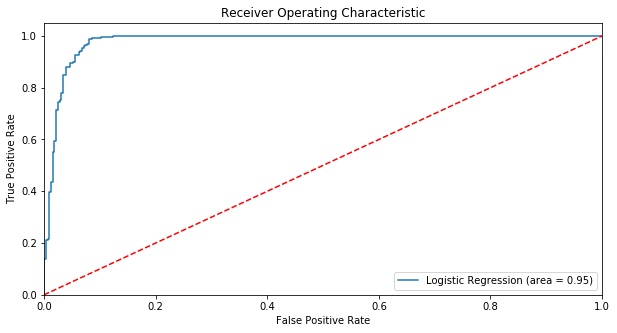

In [17]:
# ROC Curve
logit2_roc_auc = roc_auc_score(Yl_test, logreg2.predict(Xl_test))
fpr2, tpr2, thresholds2 = roc_curve(Yl_test, logreg2.predict_proba(Xl_test)[:,1])
plt.figure(figsize = (10,5))
plt.plot(fpr2, tpr2, label = 'Logistic Regression (area = %0.2f)' %logit2_roc_auc)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = "lower right")
plt.show()